# 03 - Case Memory & FAISS Index

Build the case memory and FAISS index for RAG-based explainable fraud detection.

**Objectives:**
1. Load embeddings from trained GraphSAGE model
2. Select representative cases (illicit, licit, edge cases)
3. Build FAISS index for fast similarity search
4. Test retrieval of similar cases

## 1. Setup & Imports

In [20]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Imports complete!")

Imports complete!


## 2. Load Embeddings from Baseline Model

In [22]:
# Load saved embeddings
embeddings_path = '../baseline/checkpoints/node_embeddings.npz'
data = np.load(embeddings_path)

embeddings = data['embeddings']
fraud_scores = data['fraud_scores']
predictions = data['predictions']
labels = data['labels']

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Fraud scores range: [{fraud_scores.min():.4f}, {fraud_scores.max():.4f}]")
print(f"Labels: {np.unique(labels, return_counts=True)}")

Loaded embeddings: (203769, 64)
Fraud scores range: [0.0000, 1.0000]
Labels: (array([-1,  0,  1]), array([157205,  42019,   4545]))


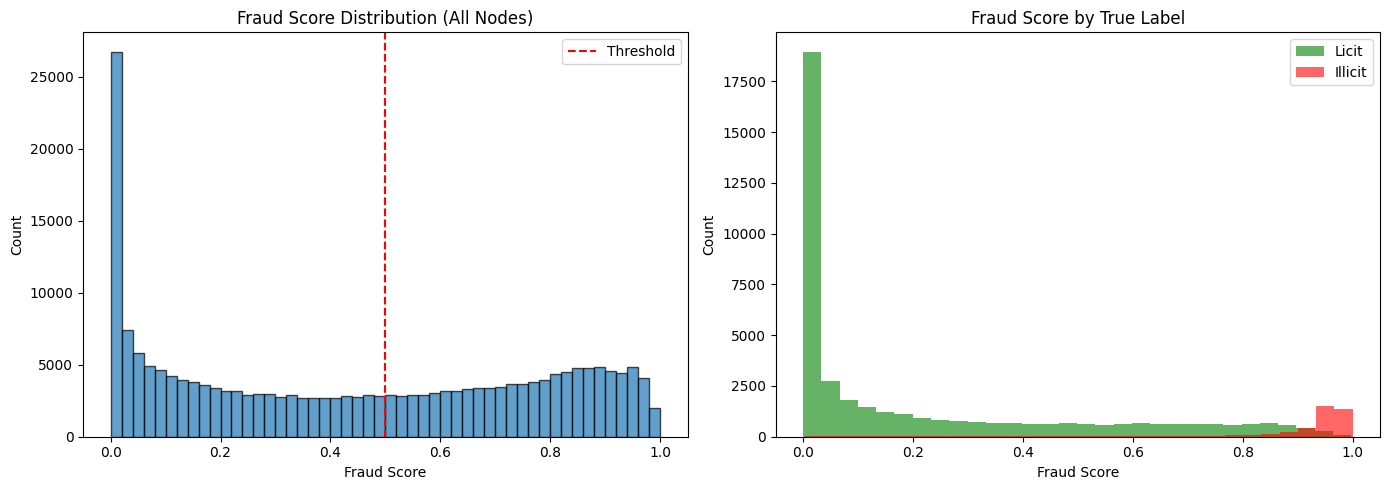

In [3]:
# Analyze fraud score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(fraud_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Fraud Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Fraud Score Distribution (All Nodes)')
axes[0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0].legend()

# By label (labeled nodes only)
labeled_mask = labels != -1
for label, name, color in [(0, 'Licit', 'green'), (1, 'Illicit', 'red')]:
    mask = labels == label
    axes[1].hist(fraud_scores[mask], bins=30, alpha=0.6, label=name, color=color)

axes[1].set_xlabel('Fraud Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Fraud Score by True Label')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Case Selection Strategy

Select a balanced set of cases for the memory:
- **High-confidence illicit**: fraud_score > 0.85 and label = 1
- **High-confidence licit**: fraud_score < 0.15 and label = 0
- **Edge cases**: fraud_score ∈ [0.4, 0.6] (uncertain predictions)

In [26]:
from src.memory.case_selector import CaseSelector

# Initialize case selector with config
selector = CaseSelector(
    num_illicit=350,
    num_licit=350,
    num_edge=300,
    illicit_threshold=0.85,
    licit_threshold=0.15,
    edge_range=(0.4, 0.6),
    diversity_weight=0.5
)

# Select cases with balanced strategy
selected_indices, stats = selector.select(
    labels=labels,
    fraud_scores=fraud_scores,
    embeddings=embeddings,
    strategy='balanced'
)

print(f"Selection Statistics:")
print(f"  Illicit: {stats.get('illicit', 0)} selected from {stats.get('illicit_available', 0)} available")
print(f"  Licit: {stats.get('licit', 0)} selected from {stats.get('licit_available', 0)} available")
print(f"  Edge: {stats.get('edge', 0)} selected from {stats.get('edge_available', 0)} available")
print(f"  Total: {stats.get('total', 0)}")

Selection Statistics:
  Illicit: 350 selected from 4058 available
  Licit: 350 selected from 38995 available
  Edge: 300 selected from 577 available
  Total: 1000


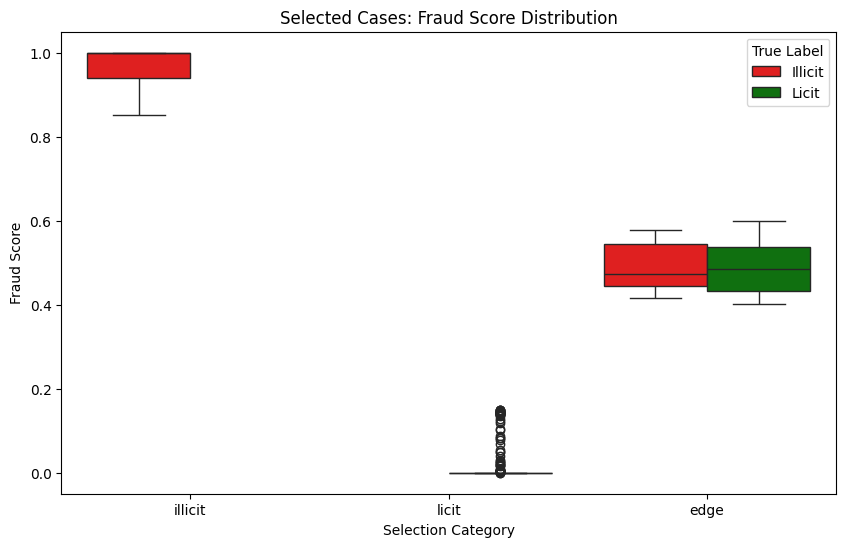

In [27]:
# Visualize selected cases
selected_scores = fraud_scores[selected_indices]
selected_labels = labels[selected_indices]

# Determine category based on thresholds
categories = []
for idx in selected_indices:
    score = fraud_scores[idx]
    if score >= 0.85:
        categories.append('illicit')
    elif score <= 0.15:
        categories.append('licit')
    else:
        categories.append('edge')

# Create DataFrame for visualization
df = pd.DataFrame({
    'fraud_score': selected_scores,
    'true_label': ['Illicit' if l == 1 else 'Licit' if l == 0 else 'Unknown' for l in selected_labels],
    'category': categories
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='fraud_score', hue='true_label', palette={'Illicit': 'red', 'Licit': 'green', 'Unknown': 'gray'})
plt.title('Selected Cases: Fraud Score Distribution')
plt.xlabel('Selection Category')
plt.ylabel('Fraud Score')
plt.legend(title='True Label')
plt.show()

## 4. Build Case Memory

In [28]:
from src.memory.case_store import CaseMemory

# Load original data for features
from src.data.elliptic_loader import EllipticDataLoader
loader = EllipticDataLoader('../data/elliptic_bitcoin_dataset')
features, orig_labels, edge_index = loader.load()

print(f"Loaded features: {features.shape}")

Loading Elliptic dataset...
  Features: 203,769 nodes, 167 columns
  Labels: 203,769 entries
  Edges: 234,355 directed edges
  Node mapping: 203,769 unique nodes
  Normalizing features...
  Features shape: (203769, 166)
  Time steps: 1 to 49 (49 unique)
  Label distribution:
    unknown: 157,205 (77.15%)
    licit: 42,019 (20.62%)
    illicit: 4,545 (2.23%)
  Edge index shape: (2, 234355)
Loaded features: (203769, 166)


In [29]:
# Create case memory and add selected cases
case_memory = CaseMemory(storage_dir='../case_memory')

for idx in selected_indices:
    node_idx = int(idx)
    case_memory.add_case(
        node_idx=node_idx,
        embedding=embeddings[node_idx],
        fraud_score=float(fraud_scores[node_idx]),
        predicted_label='illicit' if predictions[node_idx] == 1 else 'licit',
        true_label='illicit' if labels[node_idx] == 1 else 'licit' if labels[node_idx] == 0 else 'unknown',
        explanation={},  # Will add GNNExplainer output later
        time_step=0,
        in_degree=0,
        out_degree=0
    )

print(f"Case memory built with {len(case_memory.cases)} cases")

Case memory built with 1000 cases


In [30]:
# View sample cases
print("Sample Illicit Case:")
illicit_cases = case_memory.get_cases(label='illicit')
if illicit_cases:
    c = illicit_cases[0]
    print(f"  Node: {c.node_idx}")
    print(f"  Fraud Score: {c.fraud_score:.4f}")
    print(f"  True Label: {c.true_label}")

print("\nSample Licit Case:")
licit_cases = case_memory.get_cases(label='licit')
if licit_cases:
    c = licit_cases[0]
    print(f"  Node: {c.node_idx}")
    print(f"  Fraud Score: {c.fraud_score:.4f}")
    print(f"  True Label: {c.true_label}")

Sample Illicit Case:
  Node: 72254
  Fraud Score: 0.9995
  True Label: illicit

Sample Licit Case:
  Node: 97696
  Fraud Score: 0.0880
  True Label: licit


## 5. Build FAISS Index

In [31]:
# Reload module to pick up fix
import importlib
import src.retrieval
importlib.reload(src.retrieval)

from src.retrieval.faiss_index import FAISSIndex

# Get embeddings for selected cases
case_embeddings = case_memory.get_embeddings()
print(f"Case embeddings shape: {case_embeddings.shape}")

# Build FAISS index
faiss_index = FAISSIndex(embedding_dim=64, index_type='flat', metric='l2')
faiss_index.build(case_embeddings)

print(f"FAISS index built with {faiss_index.num_vectors} vectors")

Case embeddings shape: (1000, 64)
Built FAISS index: 1000 vectors, dim=64, type=flat
FAISS index built with 1000 vectors


## 6. Test Retrieval

In [32]:
from src.retrieval.retriever import Retriever

# Initialize retriever
retriever = Retriever(faiss_index, case_memory)

# Test with a random query node (not in case memory)
test_node_idx = 12345
query_embedding = embeddings[test_node_idx]

print(f"Query node {test_node_idx}:")
print(f"  Fraud score: {fraud_scores[test_node_idx]:.4f}")
print(f"  True label: {'illicit' if labels[test_node_idx] == 1 else 'licit' if labels[test_node_idx] == 0 else 'unknown'}")
print(f"  Prediction: {'illicit' if predictions[test_node_idx] == 1 else 'licit'}")

Query node 12345:
  Fraud score: 0.0099
  True label: unknown
  Prediction: licit


In [33]:
# Retrieve similar cases
similar_cases = retriever.retrieve(query_embedding, k=5)

print(f"\nTop 5 Similar Cases:")
print("-" * 70)
for i, result in enumerate(similar_cases):
    case = result['case']
    print(f"{i+1}. Case {case.case_id}")
    print(f"   Similarity: {result['similarity']:.4f}")
    print(f"   Fraud Score: {case.fraud_score:.4f}")
    print(f"   True Label: {case.true_label}")
    print(f"   Predicted: {case.predicted_label}")
    print()


Top 5 Similar Cases:
----------------------------------------------------------------------
1. Case 400
   Similarity: 0.2599
   Fraud Score: 0.0038
   True Label: licit
   Predicted: licit

2. Case 452
   Similarity: 0.2524
   Fraud Score: 0.0049
   True Label: licit
   Predicted: licit

3. Case 465
   Similarity: 0.2318
   Fraud Score: 0.0023
   True Label: licit
   Predicted: licit

4. Case 431
   Similarity: 0.2215
   Fraud Score: 0.0022
   True Label: licit
   Predicted: licit

5. Case 354
   Similarity: 0.2179
   Fraud Score: 0.0016
   True Label: licit
   Predicted: licit



In [34]:
# Test retrieval for a known illicit transaction
illicit_indices = np.where(labels == 1)[0]
test_illicit_idx = illicit_indices[100]  # Pick an illicit node

print(f"Query: Known Illicit Node {test_illicit_idx}")
print(f"  Fraud score: {fraud_scores[test_illicit_idx]:.4f}")
print()

similar = retriever.retrieve(embeddings[test_illicit_idx], k=5)
print("Retrieved Cases:")
for i, r in enumerate(similar):
    print(f"  {i+1}. {r['case'].true_label} (score: {r['case'].fraud_score:.3f}, sim: {r['similarity']:.3f})")

Query: Known Illicit Node 36965
  Fraud score: 0.9956

Retrieved Cases:
  1. illicit (score: 0.994, sim: 0.964)
  2. illicit (score: 0.994, sim: 0.961)
  3. illicit (score: 0.996, sim: 0.932)
  4. illicit (score: 0.995, sim: 0.919)
  5. illicit (score: 0.994, sim: 0.899)


In [35]:
# Test retrieval for a known licit transaction
licit_indices = np.where(labels == 0)[0]
test_licit_idx = licit_indices[100]  # Pick a licit node

print(f"Query: Known Licit Node {test_licit_idx}")
print(f"  Fraud score: {fraud_scores[test_licit_idx]:.4f}")
print()

similar = retriever.retrieve(embeddings[test_licit_idx], k=5)
print("Retrieved Cases:")
for i, r in enumerate(similar):
    print(f"  {i+1}. {r['case'].true_label} (score: {r['case'].fraud_score:.3f}, sim: {r['similarity']:.3f})")

Query: Known Licit Node 330
  Fraud score: 0.0000

Retrieved Cases:
  1. licit (score: 0.000, sim: 0.201)
  2. licit (score: 0.000, sim: 0.142)
  3. licit (score: 0.000, sim: 0.106)
  4. licit (score: 0.000, sim: 0.102)
  5. licit (score: 0.000, sim: 0.099)


## 7. Save Case Memory & FAISS Index

In [17]:
import os

# Save case memory (uses storage_dir from initialization)
case_memory.save()
case_memory_path = '../case_memory'
print(f"Case memory saved to: {case_memory_path}")

# Save FAISS index
faiss_path = os.path.join(case_memory_path, 'faiss.index')
faiss_index.save(faiss_path)
print(f"FAISS index saved to: {faiss_path}")

Saved 1000 cases to ../case_memory
Case memory saved to: ../case_memory
Saved FAISS index to ../case_memory/faiss.index
FAISS index saved to: ../case_memory/faiss.index


In [18]:
# Verify we can reload
loaded_memory = CaseMemory.load(case_memory_path)
loaded_index = FAISSIndex(embedding_dim=64)
loaded_index.load(faiss_path)

print(f"Reloaded case memory: {len(loaded_memory.cases)} cases")
print(f"Reloaded FAISS index: {loaded_index.num_vectors} vectors")

Loaded 1000 cases from ../case_memory
Loaded FAISS index from ../case_memory/faiss.index: 1000 vectors
Reloaded case memory: 1000 cases
Reloaded FAISS index: 1000 vectors


## 8. Summary

In [36]:
print("=" * 60)
print("CASE MEMORY SUMMARY")
print("=" * 60)
print(f"\nTotal cases in memory: {len(case_memory.cases)}")
print(f"  • Illicit cases: {len(case_memory.get_cases(label='illicit'))}")
print(f"  • Licit cases: {len(case_memory.get_cases(label='licit'))}")
print(f"\nFAISS Index:")
print(f"  • Embedding dimension: 64")
print(f"  • Index type: Flat L2")
print(f"  • Vectors indexed: {faiss_index.num_vectors}")
print(f"\nSaved artifacts:")
print(f"  • Case memory: {case_memory_path}")
print(f"  • FAISS index: {faiss_path}")
print(f"\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("1. Build ICL prompts from retrieved cases")
print("2. Test end-to-end inference pipeline")
print("3. Integrate with LLM for explanations")

CASE MEMORY SUMMARY

Total cases in memory: 1000
  • Illicit cases: 378
  • Licit cases: 622

FAISS Index:
  • Embedding dimension: 64
  • Index type: Flat L2
  • Vectors indexed: 1000

Saved artifacts:
  • Case memory: ../case_memory
  • FAISS index: ../case_memory/faiss.index

NEXT STEPS
1. Build ICL prompts from retrieved cases
2. Test end-to-end inference pipeline
3. Integrate with LLM for explanations
